In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('default')

## Description

In [3]:
df_id=pd.read_csv('../Data/Most_popular_id_2019_2021.csv').iloc[:,[0,1,2,4]].astype(str)
articles=pd.read_csv('../Data/articles_data.csv')
articles.shape

(13688, 21)

## For Table A1

In [4]:
descr=articles.describe(percentiles=[], include=np.object).T
#print(descr.to_latex(caption='Metadata fields description', label='metadata', ))
descr

,count,unique,top,freq
link,13687,13687,https://www.nytimes.com/2019/11/30/us/politics...,1
headline_main,13688,13684,Wisconsin Supreme Court Strikes Down Stay-at-H...,2
abstract,13552,13527,And what else you need to know today.,9
snippet,13424,13399,And what else you need to know today.,9
lead_paragraph,13457,12991,To hear more audio stories from publishers lik...,83
print_section,10529,33,A,6173
print_page,10532,66,1,2987
source,13554,4,The New York Times,13542
pub_date,13554,13139,2020-11-13T10:00:21+0000,4
document_type,13554,3,article,13380


## Overlap

In [5]:
df=pd.read_csv('../Data/Most_popular_id_2019_2021.csv')
types=['emailed', 'facebook']
pairs=[types]
values=[]
LR=[]
ND=[]

def calc(st, cat, days=False):
    value=0
    if days:
        df2=df.groupby(by='id_'+cat).count()
    else: #(rank)
        df2=df.groupby(by='id_'+cat).min()
    for elem in st:
        value+=df2['rank'][elem]
    value=value/len(st)
    return value

for i in range(2):
    unique=set(df['id_'+types[i]])-set(df['id_'+types[1-i]])
    values.append(len(unique))
    LR.append('Highest rank: \n'+str(np.round( calc(unique, types[i]),2)))
    ND.append('Number of days: \n'+str(np.round( calc(unique, types[i], days=True),2)))
    
    print(types[i], len(set(df['id'+'_'+types[i]])), '; unique', types[i], len(unique))
    
inter=set(df['id_emailed']).intersection(set(df['id_facebook']))
values.append(len(inter))
print('intercetion of all:', len(inter))

LR.append(types[0]+': '+str(np.round( calc(inter, types[0]),2))+'\n'+types[1]+': '+str(np.round( calc(inter, types[1]),2)))
ND.append(types[0]+': '+str(np.round( calc(inter, types[0], days=True),2))+'\n'+types[1]+': '+str(np.round( calc(inter, types[1], days=True),2)))


emailed 9284 ; unique emailed 6440
facebook 7248 ; unique facebook 4404
intercetion of all: 2844


### Average highest rank and number of days

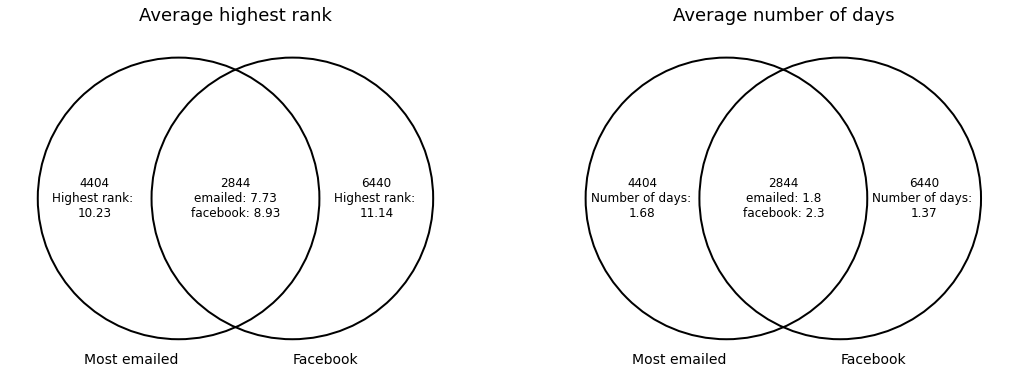

In [6]:
fig, axs = plt.subplots(figsize=(18,16),nrows=1, ncols=2) 
titles=['Average highest rank', 'Average number of days']
data=[LR, ND]

for i in range(2):
    axs[i].set_title(titles[i], fontsize=18)
    v=venn2_unweighted(subsets = (values[0], values[1], values[2]) 
        , set_labels = ('Most emailed', 'Facebook'), alpha = 0.0, set_colors=('tab:blue', 'tab:blue'), ax=axs[i])
    v2=venn2_circles(subsets = (1, 1, 1), linewidth=2, color='k', ax=axs[i])

    labels=['01','10','11']
    for j in range(3):
        v.get_label_by_id(labels[j]).set_text(str(values[j])+str('\n')+data[i][j])
        v.get_label_by_id(labels[j]).set_fontsize(12)

    for text in v.set_labels:
        text.set_fontsize(14)
plt.show()

## Figure A1 (left) and A3 (right)

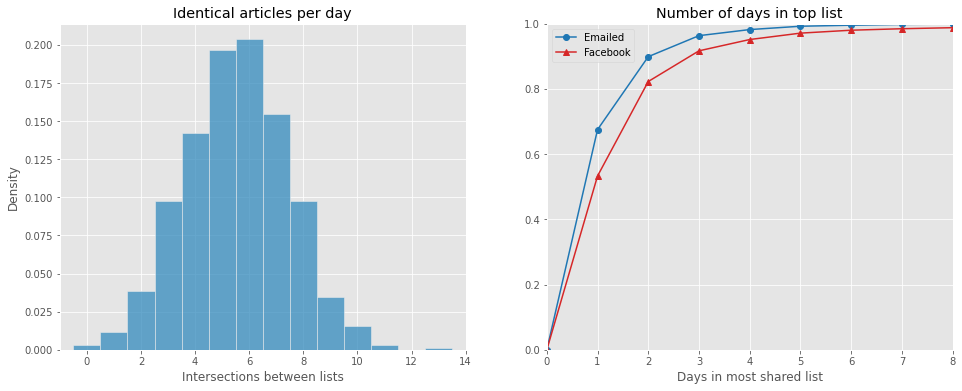

In [8]:
fig, axs = plt.subplots(figsize=(16, 6),nrows=1, ncols=2) #, sharey=True 
titles=['Identical articles per day', 'Identical articles×rank per day']

#first
dates=df['date'].unique()
intersections=[]
for date in dates:
    st=set(df[df['date']==date]['id_'+types[0]]).intersection(set(df[df['date']==date]['id_'+types[1]]))
    intersections.append(len(st))

sns.histplot(intersections, ax=axs[0], discrete = True, stat="density")
axs[0].set_xlim(-1,14)
axs[0].set_xlabel('Intersections between lists')
axs[0].set_title('Identical articles per day')

#second
for i in range(2):
    l=list(df['id_'+types[i]])
    a=[l.count(x) for x in set(l)]
    values, counts = np.unique(a, return_counts=True)
    
    axs[1].plot([0]+list(values), [0]+list(np.cumsum(counts/sum(counts))), 
                color=['tab:blue', 'tab:red'][i], marker=['o', '^'][i]) #linestyle=['solid','dashed'][i],
    axs[1].set_ylim(0,1)

axs[1].set_xlabel('Days in most shared list')
axs[1].set_title('Number of days in top list')
axs[1].legend(["Emailed", "Facebook"])
axs[1].set_xlim(0,8)
plt.show()

### Headline wordcloud

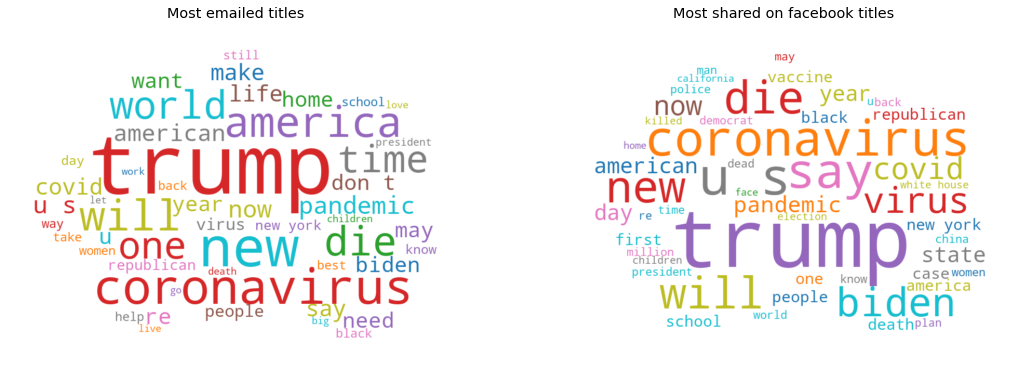

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

In [9]:
mask = np.array(Image.open("cloud.png"))
articles=pd.read_csv('../Data/articles_data.csv').iloc[:, :3]

fig, axs = plt.subplots(figsize=(18, 8),nrows=1, ncols=2) 
for i in range(2):
    text=articles[articles.id.isin(df['id_'+types[i]])]
    text = ' '.join(text['headline_main'].apply(lambda x : x.replace(',', ' ').replace('. ',
                    ' ').replace('?', ' ').replace('’s', ' ').lower()))
    plt.figure(figsize=(14,14))
    wordcloud = WordCloud(max_words=50, background_color="white", prefer_horizontal=1, 
                          mask=mask, colormap=plt.get_cmap('tab10')).generate(text) #, contour_width=1, min_word_length

    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title('Most '+'shared on '*(i)+str(types[i])+' titles')

### By Year

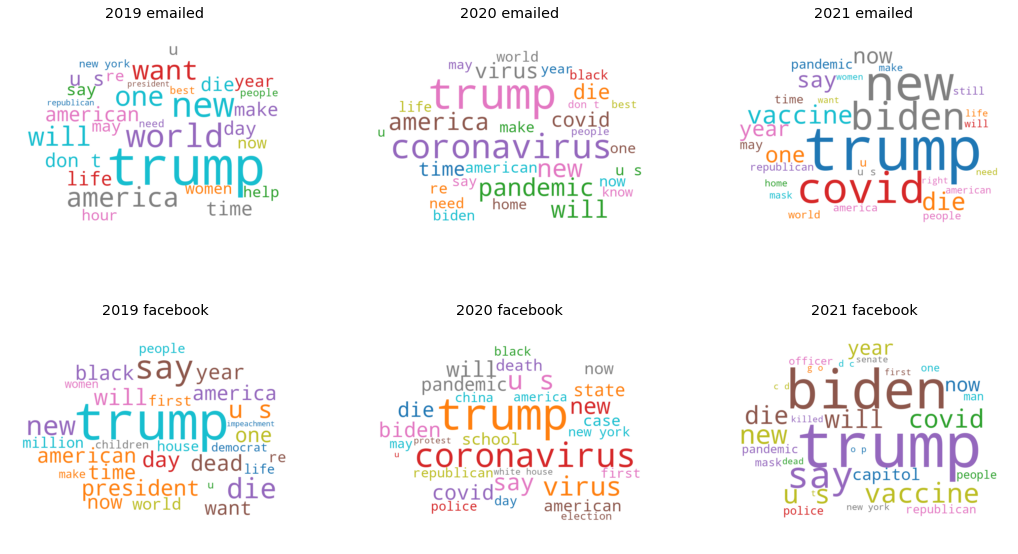

In [10]:
df['year']=df['date'].apply(lambda x: str(x)[:4])

fig, axs = plt.subplots(figsize=(18, 10),nrows=2, ncols=3)

for year in df['year'].unique():
    for i in range(2):
        text=articles[articles.id.isin(df[df['year']==year]['id_'+types[i]])]
        text = ' '.join(text['headline_main'].apply(lambda x : x.replace(',', ' ').replace('. ',
                    ' ').replace('?', ' ').replace('’s', ' ').lower()))
    
#         text = ' '.join(df[df['year']==year]['title_'+types[i]].apply(lambda x : x.replace(',', ' ').replace('. ',
#                     ' ').replace('?', ' ').replace('’s', ' ').lower()))
        wordcloud = WordCloud(max_words=30, background_color="white", prefer_horizontal=1, 
                          mask=mask, colormap=plt.get_cmap('tab10')).generate(text)
        axs[i,int(year)-2019].imshow(wordcloud, interpolation='bilinear')
        axs[i,int(year)-2019].axis("off")
        axs[i,int(year)-2019].set_title(year+' '+types[i])


## Summarizing the type of articles in each bucket

Every article counted as much times as it appears in daily data

### Days after release

In [11]:
popular=pd.read_csv('../Data/Most_popular_id_2019_2021.csv').drop(columns=['id_viewed'])
articles=pd.read_csv('../Data/articles_data.csv')[['id', 'pub_date']]
popular['date'] = pd.to_datetime(popular['date']).dt.date
articles['pub_date'] = pd.to_datetime(articles['pub_date']).dt.date

popular=pd.merge(popular, articles, left_on='id_emailed', right_on='id', how='left')
popular['emailed_days']=(popular['date']-popular['pub_date']).dt.days
popular.drop(columns=['id', 'pub_date'], inplace=True)

popular=pd.merge(popular, articles, left_on='id_facebook', right_on='id', how='left')
popular['facebook_days']=(popular['date']-popular['pub_date']).dt.days
#popular.drop(columns=['id', 'pub_date'], inplace=True)

emailed_days median: 2.0 mean: 28.603235082674335
facebook_days median: 2.0 mean: 47.13357137652117


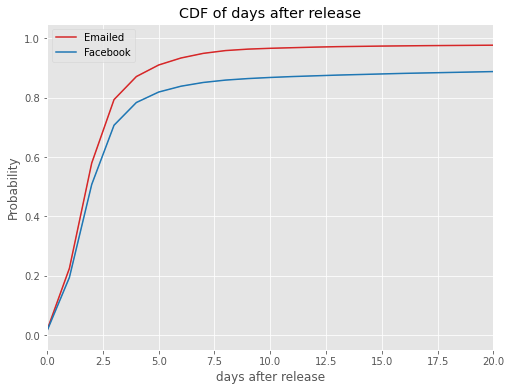

In [14]:
fig=plt.figure(figsize=(8,6))
names=['emailed_days', 'facebook_days']
for i in range(2):
    a=popular[names[i]].dropna().astype(int).to_list()
    print(names[i], 'median:', np.median(a), 'mean:', np.mean(a))
    x, y = sorted(a), np.arange(1, len(a)+1) / len(a)
    sns.lineplot(x=x,y=y, color=['tab:red', 'tab:blue'][i])    
plt.xlim((0,20))
plt.xlabel('days after release')
plt.ylabel('Probability')
plt.legend(["Emailed", "Facebook"])
plt.title('CDF of days after release')
plt.show()

#### Outliers 

In [15]:
print(popular[popular.emailed_days>100].shape)
print(popular[popular.emailed_days>14].shape)
print(popular[popular.facebook_days>100].shape)
print(popular[popular.facebook_days>14].shape)

(204, 8)
(364, 8)
(650, 8)
(1655, 8)


## Word count

In [16]:
popular=pd.read_csv('../Data/Most_popular_id_2019_2021.csv')
articles=pd.read_csv('../Data/articles_data.csv')
link_type=['id_emailed', 'id_facebook']
titles=['Most emailed', 'Most shared on Facebook']
df_list=[pd.merge(popular, articles, how="inner", left_on=clmn, right_on='id').loc[:, ['id','word_count']] 
         for clmn in link_type]
for i in range(2):
    df_list[i]=df_list[i][df_list[i]['word_count']!=0.0]

For every observation (not unique articles)
Most emailed ; mean: 1539.78 sd: 1182.085
Most shared on Facebook ; mean: 1393.456 sd: 997.168


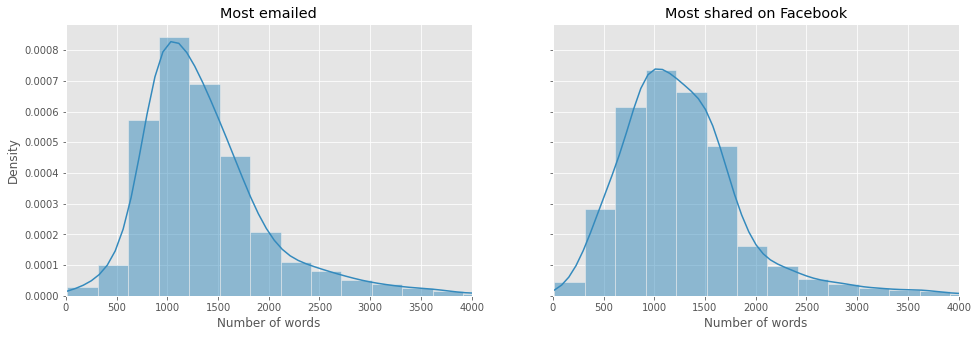

In [17]:
stat_words=[]
print('For every observation (not unique articles)')
fig, axs = plt.subplots(figsize=(16, 5),nrows=1, ncols=2, sharey=True) 
for i in range(2):
    a=df_list[i]['word_count']
    stat_words.append(pd.DataFrame(a).describe().rename(columns={'word_count':'Word_count_'+types[i]}))
    #print(df_list[i].shape)
    sns.histplot(a, stat="density", ax=axs[i], kde=True, binwidth=300)
    axs[i].set_xlabel('Number of words')
    axs[i].set_title(titles[i])
    axs[i].set_xlim((0,4000))
    #print('max number of days for', types[i], 'is', max(a))
    print(titles[i], '; mean:', np.round(np.mean(a), 3), 'sd:', np.round(np.std(a),3))
plt.show()

In [18]:
pd.concat(stat_words, axis=1).T

,count,mean,std,min,25%,50%,75%,max
Word_count_emailed,13627.0,1539.779775,1182.128180,16.0,955.0,1257.0,1663.00,15619.0
Word_count_facebook,13500.0,1393.455704,997.204675,16.0,883.0,1212.0,1570.25,14136.0


## Histograms for categorical variables

In [19]:
a_data=pd.read_csv('../Data/articles_data.csv')
df_list=[pd.merge(popular, a_data, how="inner", left_on=clmn, right_on='id').loc[:, 
                ['id','section_name', 'news_desk', 'type_of_material', 'document_type']] for clmn in link_type]

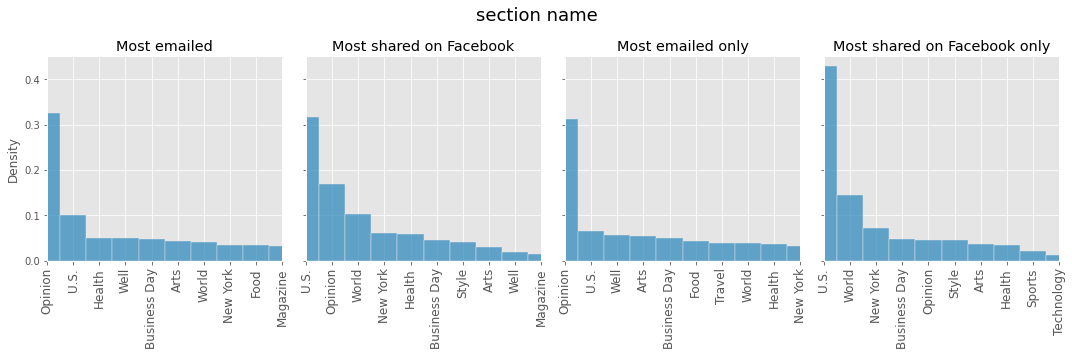

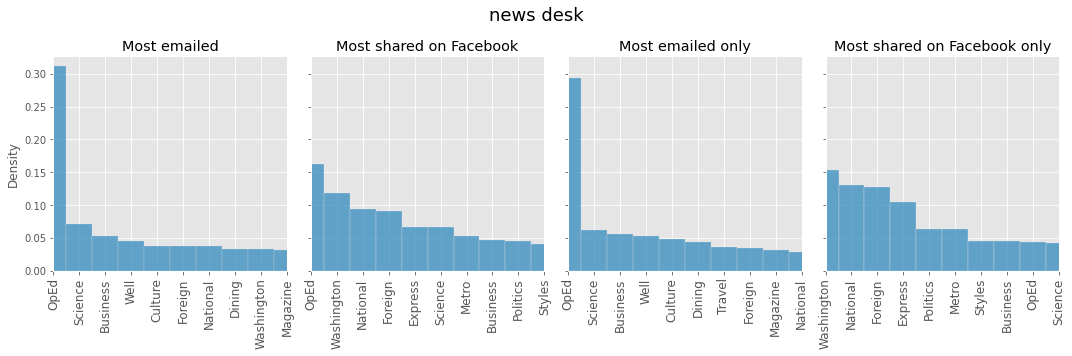

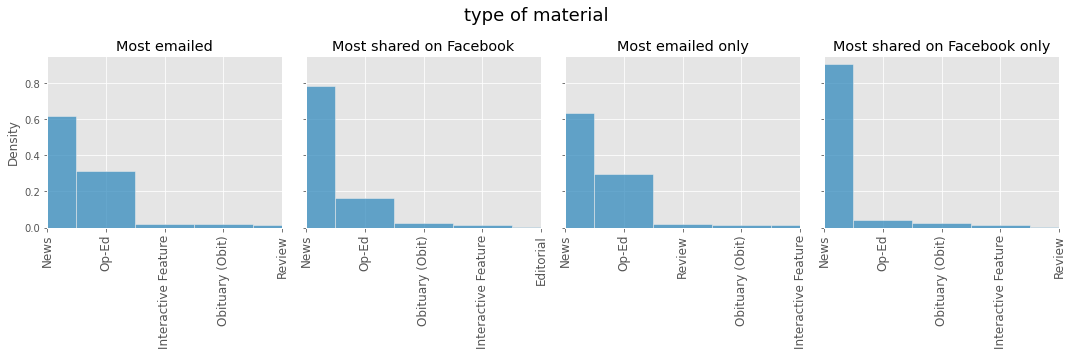

In [20]:
titles=['Most emailed', 'Most shared on Facebook']
def plot_hist_if(column_name, amount=10, unique=False):
    #print(column_name)
    fig, axs = plt.subplots(figsize=(15, 5),nrows=1, ncols=4, sharey=True) 
    for j in range(2):
        for i in range(2):
            if j==0:
                a=df_list[i].loc[:,['id',column_name]]
            else:
                ids=set(df_list[i]['id'])-set(df_list[1-i]['id'])
                a=df_list[i][df_list[i].id.isin(ids)].loc[:,['id',column_name]]
                
            if unique:
                a=a.drop_duplicates(subset='id', keep='first', ignore_index=True)
            a=a[~a[column_name].isna()]
            freq=[[sum(a[column_name]==name),name] for name in a[column_name].unique()]
            freq.sort(key=lambda x: x[0], reverse=True)
            new_lst_of_names=[x[1] for x in freq for i in range(x[0])]
            sns.histplot(new_lst_of_names, stat="density", ax=axs[i+2*j], hue_order=[x[1] for x in freq], )
            axs[i+2*j].set_title(titles[i]+' only'*j)
            axs[i+2*j].set_xlim((0,amount))
            axs[i+2*j].tick_params(axis='x', labelrotation=90, labelsize='large')
    fig.suptitle(' '.join(column_name.split('_')), fontsize=18)
    fig.tight_layout() 
    plt.show()
# for column_name, i in zip(['section_name', 'news_desk', 'type_of_material', 'document_type'], [9,9,4,1]):
#     plot_hist_if(column_name, i)

for column_name, i in zip(['section_name', 'news_desk', 'type_of_material'], [9,9,4]):
    plot_hist_if(column_name, i)

## Figure A2a

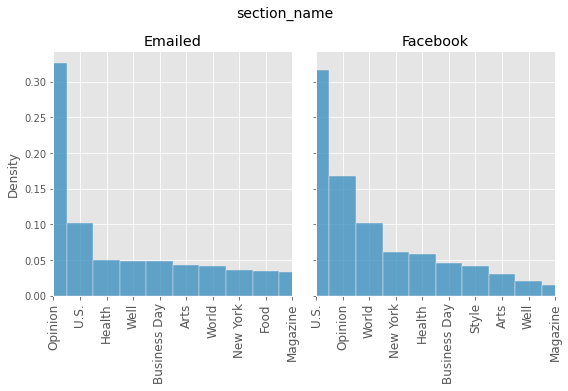

In [21]:
def plot_hist_if(column_name, amount=10, unique=False):
    #print(column_name)
    fig, axs = plt.subplots(figsize=(8, 5.5),nrows=1, ncols=2, sharey=True) 
    for i in range(2):
        a=df_list[i].loc[:,['id',column_name]]
        if unique:
            a=a.drop_duplicates(subset='id', keep='first', ignore_index=True)
        a=a[~a[column_name].isna()]
        freq=[[sum(a[column_name]==name),name] for name in a[column_name].unique()]
        freq.sort(key=lambda x: x[0], reverse=True)
        new_lst_of_names=[x[1] for x in freq for i in range(x[0])]
        sns.histplot(new_lst_of_names, stat="density", ax=axs[i], hue_order=[x[1] for x in freq], )
        axs[i].set_title(['Emailed', 'Facebook'][i])
        axs[i].set_xlim((0,amount))
        axs[i].tick_params(axis='x', labelrotation=90, labelsize='large')
    fig.suptitle(column_name, fontsize=14)
    fig.tight_layout() 
    plt.show()


for column_name, i in zip(['section_name'], [9,9]): 
    plot_hist_if(column_name, i)

## Figure A2b

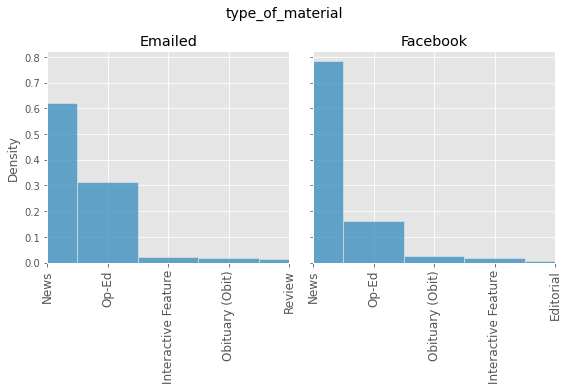

In [22]:
for column_name, i in zip(['type_of_material'], [4,4]):
    plot_hist_if(column_name, i)